## 1. Setup and Global Configuration

In [4]:
# Run this ONLY once per new runtime
#!pip install -U -q torch torchvision torchaudio
#!pip install -U -q datasets transformers timm grad-cam scikit-learn matplotlib seaborn
#!pip install timm
!pip install grad-cam

from google.colab import drive
import os, json, random
from collections import defaultdict
from datasets import load_dataset
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision.models as models
import timm
from pathlib import Path

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
from torchvision.transforms import functional as TF


# config
seed = 42
batch_size = 32
num_epochs = 10
lr = 1e-3
random.seed(seed)
torch.manual_seed(seed)



## 2. Drive Mount and Paths

In [31]:
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/wikiart_project"
IMG_DIR = f"{BASE_DIR}/images"
META_DIR = f"{BASE_DIR}/meta"
SPLIT_DIR = f"{BASE_DIR}/splits"
MODEL_DIR = f"{BASE_DIR}/models"
RESULTS_DIR = f"{BASE_DIR}/results"

GRADCAM_DIR = f"{BASE_DIR}/gradcam"
CNN_DIR = f"{GRADCAM_DIR}/cnn"
VIT_DIR = f"{GRADCAM_DIR}/vit"
RESNET_DIR = f"{GRADCAM_DIR}/resnet"



for d in [IMG_DIR, META_DIR, SPLIT_DIR, MODEL_DIR, RESULTS_DIR]:
    os.makedirs(d, exist_ok=True)

for d in [CNN_DIR, VIT_DIR, RESNET_DIR]:
    Path(d).mkdir(parents=True, exist_ok=True)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. Dataset Preparation

In [6]:
import os
from collections import Counter
import csv
from datasets import load_dataset

csv_path = f"{BASE_DIR}/style_counts.csv"

if os.path.exists(csv_path):
    print(f"Style counts already exist at {csv_path}, skipping computation.")
else:
    print("Computing style counts...")
    dataset_stream = load_dataset("huggan/wikiart",
                                  split="train",
                                  streaming=True)

    style_counts = Counter()
    total = 0

    for sample in dataset_stream:
        style = sample["style"]
        style_counts[style] += 1
        total += 1

    print("Total images:", total)
    print("Style counts:", len(style_counts))

    for style_id, count in sorted(style_counts.items(),
                                  key=lambda x: x[1],
                                  reverse=True):
        print(f"style={style_id}, count={count}")

    with open(csv_path, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["style_id", "count"])
        for style_id, count in sorted(style_counts.items(),
                                      key=lambda x: x[1],
                                      reverse=True):
            writer.writerow([style_id, count])

    print(f"Style counts saved to {csv_path}")




Style counts already exist at /content/drive/MyDrive/wikiart_project/style_counts.csv, skipping computation.


In [8]:
selected_styles = [12,21,23,9,20,24]
max_per_class = 2000

def dataset_exist(meta_dir):
  return len(os.listdir(meta_dir))>0

def prepare_dataset():

  dataset_stream = load_dataset("huggan/wikiart",
        split="train",
        streaming=True)

  class_counts = defaultdict(int)
  i=0

  for sample in dataset_stream:
    label = sample["style"]
    if label not in selected_styles:
      continue

    if class_counts[label] < max_per_class:
      image = sample["image"].convert("RGB")
      img_path = f"{IMG_DIR}/{i}.jpg"
      image.save(img_path)

      meta = {
          "style": label,
          "path": img_path
      }
      with open(f"{META_DIR}/{i}.json", "w") as f:
        json.dump(meta, f)

      class_counts[label] += 1
      i += 1

    if all(class_counts[s] >= max_per_class for s in selected_styles):
      break

  print("Dataset prepared:", class_counts)


if not dataset_exist(META_DIR):
  prepare_dataset()
else:
  print("Dataset already exists.")

Dataset already exists.


## 4. Splits

In [9]:
def create_splits():
  files = sorted([f"{META_DIR}/{f}" for f in os.listdir(META_DIR) if f.endswith(".json")])
  random.shuffle(files)

  n = len(files)
  splits = {
      "train": files[:int(0.7*n)],
      "val": files[int(0.7*n):int(0.85*n)],
      "test": files[int(0.85*n):]
  }

  for split, files in splits.items():
    with open(f"{SPLIT_DIR}/{split}.json", "w") as f:
      json.dump(files, f)

  print("Splits saved")

if not os.path.exists(f"{SPLIT_DIR}/train.json"):
  create_splits()
else:
  print("Splits already exist.")

Splits already exist.


## 5. Dataset and Dataloaders

In [10]:
style_to_idx = {style: i for i, style in enumerate(selected_styles)}
idx_to_style = {i: style for style, i in style_to_idx.items()}
num_classes = len(selected_styles)

class WikiArtDataset(Dataset):
    def __init__(self, json_files, transform=None):
        self.json_files = json_files
        self.transform = transform
        self.style_to_idx = style_to_idx

    def __len__(self):
        return len(self.json_files)

    def __getitem__(self, idx):
        with open(self.json_files[idx], "r") as f:
            meta = json.load(f)
        image = Image.open(meta["path"]).convert("RGB")
        label = self.style_to_idx[meta["style"]]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

def load_split(split):
  with open(f"{SPLIT_DIR}/{split}.json") as f:
    return json.load(f)

def get_dataloaders():
  train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

  eval_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

  train_dataset= WikiArtDataset(load_split("train"), transform=train_tf)
  val_dataset = WikiArtDataset(load_split("val"), transform=eval_tf)
  test_dataset = WikiArtDataset(load_split("test"), transform=eval_tf)

  return (
      DataLoader(train_dataset,batch_size=batch_size, shuffle=True,num_workers=2),
      DataLoader(val_dataset,batch_size=batch_size, shuffle=False,num_workers=2),
      DataLoader(test_dataset,batch_size=batch_size, shuffle=False,num_workers=2)
  )

## 6. Training & Evaluation

In [11]:
def train_one_epoch(model, loader, optimizer, criterion, device):
  model.train()
  total_loss, correct, total = 0, 0, 0

  for x, y in loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    out = model(x)
    loss = criterion(out,y)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()*x.size(0)
    correct+= (out.argmax(1)==y).sum().item()
    total += y.size(0)

  return total_loss/total, correct/total


@torch.no_grad()
def evaluate(model, loader, device):
  model.eval()
  correct, total = 0, 0
  all_preds, all_labels = [], []

  for x, y in loader:
    x, y = x.to(device), y.to(device)
    out = model(x)
    preds = out.argmax(1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(y.cpu().numpy())

    correct += (preds==y).sum().item()
    total += y.size(0)

  return correct/total, all_preds, all_labels


def save_checkpoint(model, optimizer, scheduler, epoch, best_val, model_name):
    ckpt_path = f"{MODEL_DIR}/{model_name}_ckpt.pth"
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "best_val": best_val,
    }, ckpt_path)

def load_checkpoint(model, optimizer, scheduler, model_name, device):
    ckpt_path = f"{MODEL_DIR}/{model_name}_ckpt.pth"
    if not os.path.exists(ckpt_path):
        # no checkpoint yet
        return model, optimizer, scheduler, 0, 0.0

    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])


    if "scheduler_state_dict" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    start_epoch = checkpoint["epoch"]
    best_val = checkpoint["best_val"]
    print(f"Loaded checkpoint from epoch {start_epoch} with best_val={best_val:.4f}")
    return model, optimizer, scheduler, start_epoch, best_val


def run_experiment(model, model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_loader, val_loader, test_loader = get_dataloaders()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # scheduler selection
    if isinstance(model, SimpleCNN):
        # CNN
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=3
        )
    else:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=10, eta_min=1e-5
        )

    model, optimizer, scheduler, start_epoch, best_val = load_checkpoint(
        model, optimizer, scheduler, model_name, device
    )

    early_stop_patience = 5
    epochs_no_improve = 0

    history = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    history_path = f"{RESULTS_DIR}/{model_name}_history.csv"

    for epoch in range(start_epoch, num_epochs):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )
        val_acc, _, _ = evaluate(model, val_loader, device)

        print(
            f"[{model_name}] Epoch {epoch+1}: "
            f"Train Acc:{train_acc:.4f}, Val Acc:{val_acc:.4f}"
        )

        # history update
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        pd.DataFrame(history).to_csv(history_path, index=False)

        # Scheduler step
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_acc)  
        else:
            scheduler.step()  

        # Early stopping 
        if val_acc > best_val:
            best_val = val_acc
            torch.save(model.state_dict(), f"{MODEL_DIR}/{model_name}.pth")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        save_checkpoint(model, optimizer, scheduler, epoch + 1, best_val, model_name)

        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping triggered at epoch {epoch+1}", flush=True)
            break

    # load best model and test
    model.load_state_dict(torch.load(f"{MODEL_DIR}/{model_name}.pth", map_location=device))
    test_acc, test_preds, test_labels = evaluate(model, test_loader, device)
    print(f"[{model_name}] Test Acc: {test_acc:.4f}")

    return test_preds, test_labels, history


@torch.no_grad()
def evaluate_metrics(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    precision, recall, f1_macro2, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    return acc, f1, precision, recall, all_labels, all_preds


def plot_confusion_matrix(y_true, y_pred, class_labels, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_training_curves(history, model_name):
  epochs = history["epoch"]

  plt.figure(figsize=(10,4))

  #loss
  plt.subplot(1,2,1)
  plt.plot(epochs, history["train_loss"], label="Train Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title(f"{model_name}")
  plt.grid(True)

  #accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, history["train_acc"], label="Train Acc")
  plt.plot(epochs, history["val_acc"], label="Val Acc")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title(f"{model_name} - Train vs Val Acc")
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

def count_params(model):
  total = sum(p.numel() for p in model.parameters())
  trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total, trainable


def save_test_results(y_true, y_pred, filename):
    df = pd.DataFrame({
        "true": y_true,
        "pred": y_pred
    })
    path = f"{RESULTS_DIR}/{filename}"
    df.to_csv(path, index=False)
    print(f"✅ Test results saved to {path}")




## 7. CNN From Stractch Training

In [12]:
# 1. CNN from stratch

class SimpleCNN(nn.Module):
  def __init__(self,num_classes=num_classes):
    super(SimpleCNN,self).__init__()
    self.conv1 = nn.Conv2d(3,32,kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32,64,kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1)
    self.pool= nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(0.3)
    self.fc1 = nn.Linear(128*28*28,256)
    self.fc2 = nn.Linear(256,num_classes)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)

    x = F.relu(self.conv2(x))
    x = self.pool(x)

    x = F.relu(self.conv3(x))
    x = self.pool(x)

    x= x.view(x.size(0),-1)
    x= self.dropout(F.relu(self.fc1(x)))
    x= self.fc2(x)
    return x

cnn = SimpleCNN(num_classes)
#_,_,cnn_history = run_experiment(cnn, "simplecnn")



## CNN Final Evaluation

Test Accuracy: 0.5044
Test F1 Score: 0.5032
Test Precision: 0.5058
Test Recall: 0.5044


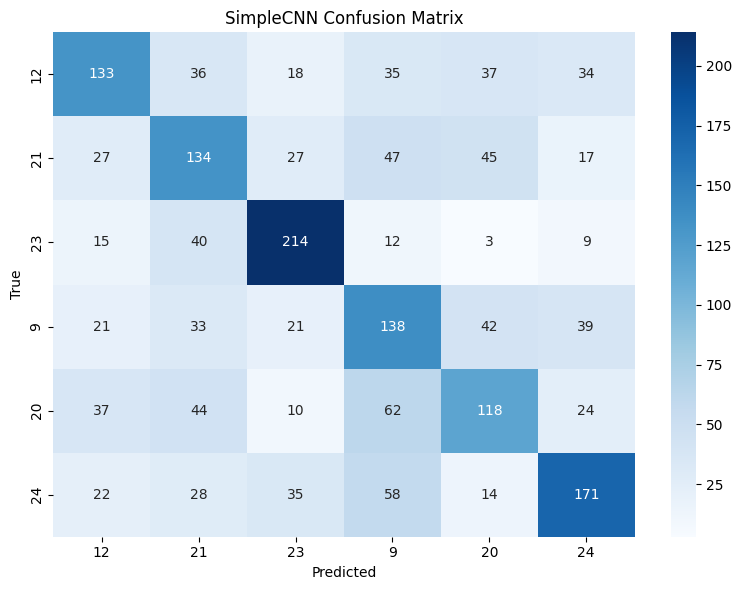

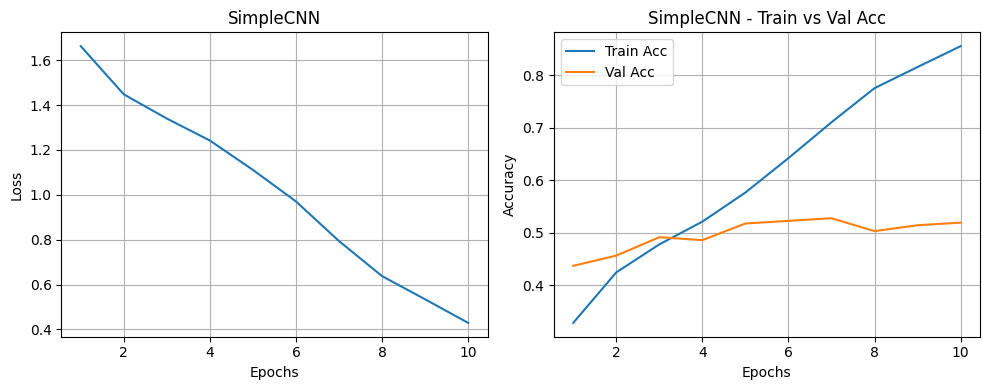

✅ Test results saved to /content/drive/MyDrive/wikiart_project/results/cnn_test_results.csv


In [10]:
# Load best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN(num_classes)
state_dict = torch.load(
    f"{MODEL_DIR}/simplecnn.pth",
    map_location=device
)
model.load_state_dict(state_dict)
model.to(device)

_, _, test_loader = get_dataloaders()

# Evaluate on test set
test_acc, test_f1,test_prec, test_rec, y_true, y_pred = evaluate_metrics(
    model, test_loader, device
)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")

# Confusion matrix
plot_confusion_matrix(
    y_true,
    y_pred,
    class_labels=[str(s) for s in selected_styles],
    title="SimpleCNN Confusion Matrix"
)

history_df = pd.read_csv(f"{RESULTS_DIR}/simplecnn_history.csv")
cnn_history = {
    "epoch": history_df["epoch"].tolist(),
    "train_loss": history_df["train_loss"].tolist(),
    "train_acc": history_df["train_acc"].tolist(),
    "val_acc": history_df["val_acc"].tolist(),
}

#Training curves
plot_training_curves(cnn_history, "SimpleCNN")

# Save results
save_test_results(y_true, y_pred, "cnn_test_results.csv")

## Pretrained Resnet50 Training

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)
resnet = resnet.to(device)

# Freeze backbone
for name, param in resnet.named_parameters():
    if "fc" not in name:
        param.requires_grad = False


_,_,resnet_history=run_experiment(resnet, "resnet50")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


Loaded checkpoint from epoch 10 with best_val=0.6822
[resnet50] Epoch 1:Train Acc:0.6869, Val Acc:0.6711
[resnet50] Epoch 2:Train Acc:0.6877, Val Acc:0.6661
[resnet50] Epoch 3:Train Acc:0.6879, Val Acc:0.6733
[resnet50] Epoch 4:Train Acc:0.6820, Val Acc:0.6711
[resnet50] Epoch 5:Train Acc:0.6800, Val Acc:0.6761
[resnet50] Epoch 6:Train Acc:0.6838, Val Acc:0.6800
[resnet50] Epoch 7:Train Acc:0.6835, Val Acc:0.6783
[resnet50] Epoch 8:Train Acc:0.6894, Val Acc:0.6744
[resnet50] Epoch 9:Train Acc:0.6926, Val Acc:0.6744
[resnet50] Epoch 10:Train Acc:0.6855, Val Acc:0.6744
[resnet50] Test Acc: 0.6689


##Pretrained Resnet50 Final Evaluation

ResNet-50 Test Accuracy: 0.6689
ResNet-50 Test F1 Score: 0.6695
ResNet-50 Test Precision: 0.6761
ResNet-50 Test Recall: 0.6695


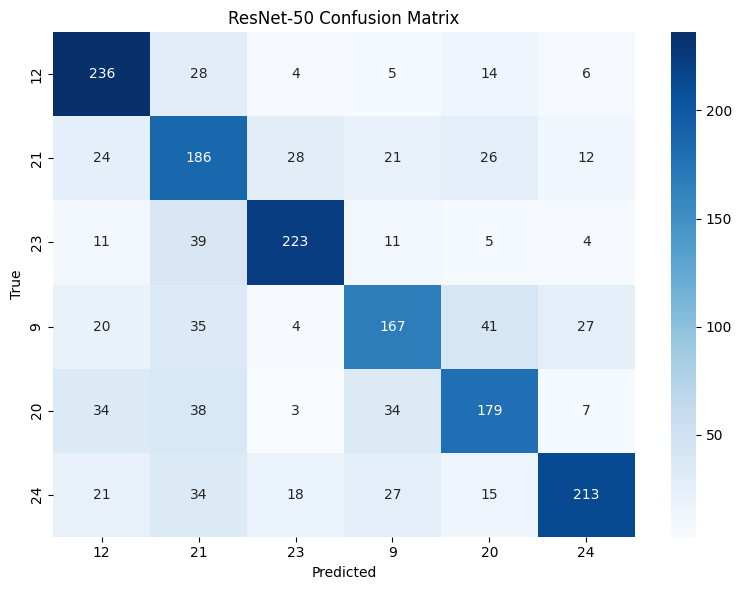

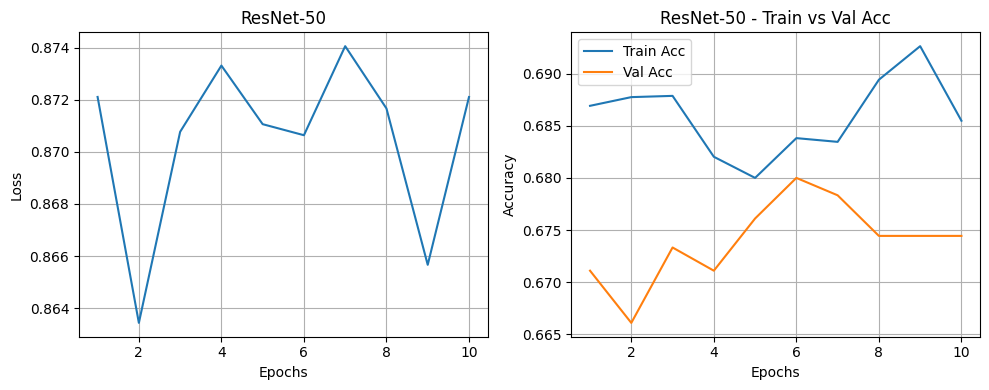

✅ Test results saved to /content/drive/MyDrive/wikiart_project/results/resnet50_test_results.csv


In [12]:
state_dict = torch.load(
    f"{MODEL_DIR}/resnet50.pth",
    map_location=device
)
resnet.load_state_dict(state_dict)
resnet.to(device)

_, _, test_loader = get_dataloaders()

test_acc, test_f1,test_prec, test_rec, y_true, y_pred = evaluate_metrics(
    resnet, test_loader, device
)

history_df = pd.read_csv(f"{RESULTS_DIR}/resnet50_history.csv")  
resnet_history = {
    "epoch": history_df["epoch"].tolist(),
    "train_loss": history_df["train_loss"].tolist(),
    "train_acc": history_df["train_acc"].tolist(),
    "val_acc": history_df["val_acc"].tolist(),
}

print(f"ResNet-50 Test Accuracy: {test_acc:.4f}")
print(f"ResNet-50 Test F1 Score: {test_f1:.4f}")
print(f"ResNet-50 Test Precision: {test_prec:.4f}")
print(f"ResNet-50 Test Recall: {test_rec:.4f}")

plot_confusion_matrix(
    y_true,
    y_pred,
    class_labels=[str(s) for s in selected_styles],
    title="ResNet-50 Confusion Matrix"
)

plot_training_curves(resnet_history, "ResNet-50")
save_test_results(y_true, y_pred, "resnet50_test_results.csv")

## Pretrained ViT Training

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vit = timm.create_model('vit_base_patch16_224', pretrained=True)
vit.head = nn.Linear(vit.head.in_features, num_classes)
vit = vit.to(device)


for name, param in vit.named_parameters():
    if "head" not in name:
        param.requires_grad = False

_,_,vit_history = run_experiment(vit, "vit_base")



Loaded checkpoint from epoch 10 with best_val=0.7111
[vit_base] Test Acc: 0.6944


## Pretrained ViT Final Evaluation

ViT Test Accuracy: 0.6944
ViT Test F1 Score: 0.6939
ViT Test Precision: 0.6956
ViT Test Recall: 0.6950


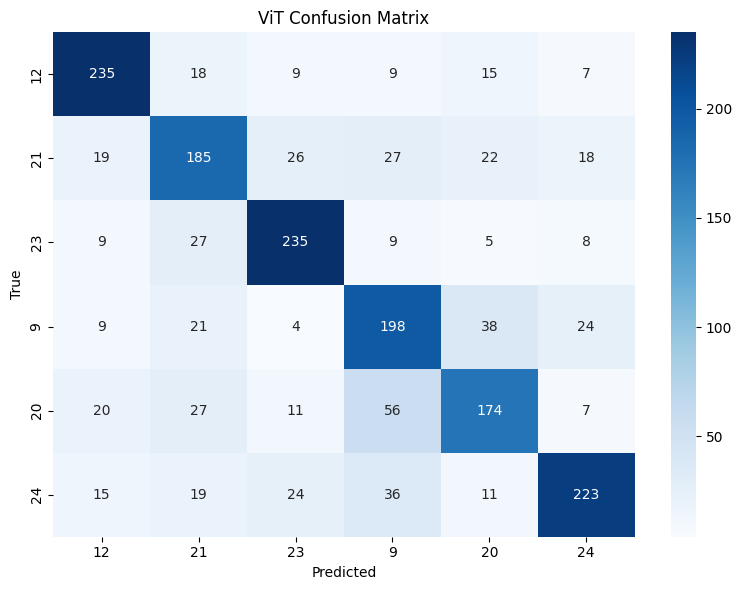

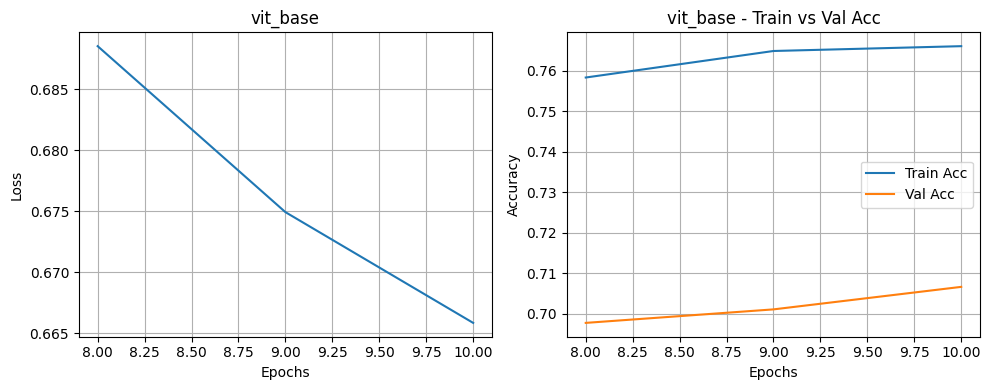

✅ Test results saved to /content/drive/MyDrive/wikiart_project/results/vit_test_results.csv


In [14]:
state_dict = torch.load(
    f"{MODEL_DIR}/vit_base.pth",
    map_location=device
)
vit.load_state_dict(state_dict)
vit.to(device)


history_df = pd.read_csv(f"{RESULTS_DIR}/vit_base_history.csv")  
vit_history = {
    "epoch": history_df["epoch"].tolist(),
    "train_loss": history_df["train_loss"].tolist(),
    "train_acc": history_df["train_acc"].tolist(),
    "val_acc": history_df["val_acc"].tolist(),
}

_, _, test_loader = get_dataloaders()
test_acc, test_f1,test_prec, test_rec, y_true, y_pred = evaluate_metrics(vit, test_loader, device)

print(f"ViT Test Accuracy: {test_acc:.4f}")
print(f"ViT Test F1 Score: {test_f1:.4f}")
print(f"ViT Test Precision: {test_prec:.4f}")
print(f"ViT Test Recall: {test_rec:.4f}")



plot_confusion_matrix(
    y_true,
    y_pred,
    class_labels=[str(s) for s in selected_styles],
    title="ViT Confusion Matrix"
)

plot_training_curves(vit_history, "vit_base")
save_test_results(y_true, y_pred, "vit_test_results.csv")



=== Evaluating SimpleCNN ===
SimpleCNN Test Accuracy: 0.5044
SimpleCNN Test F1 Score: 0.5032
SimpleCNN Total Parameters: 25785158
SimpleCNN Trainable Parameters: 25785158


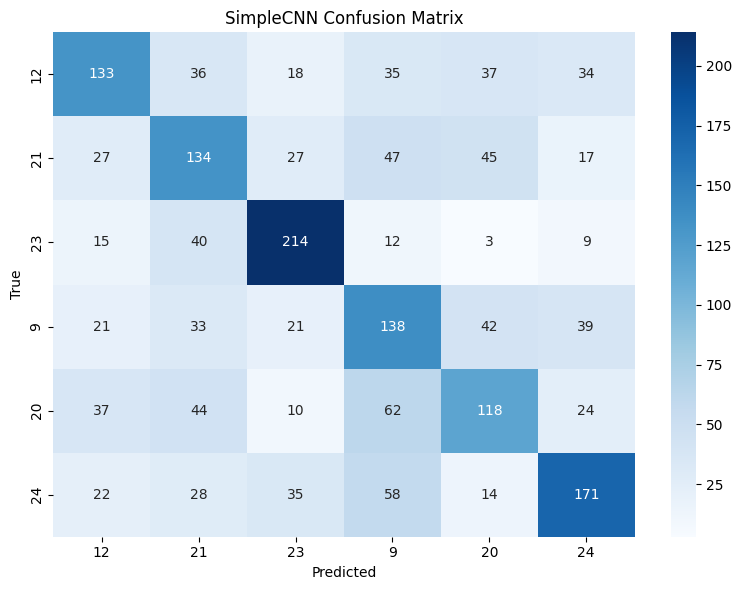

✅ Test results saved to /content/drive/MyDrive/wikiart_project/results/simplecnn_test_results.csv

=== Evaluating ResNet-50 ===
ResNet-50 Test Accuracy: 0.6689
ResNet-50 Test F1 Score: 0.6695
ResNet-50 Total Parameters: 23520326
ResNet-50 Trainable Parameters: 23520326


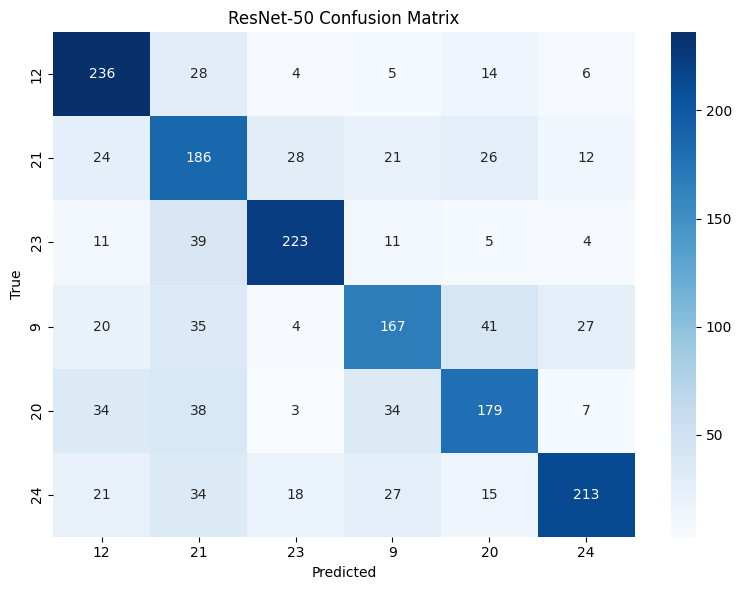

✅ Test results saved to /content/drive/MyDrive/wikiart_project/results/resnet-50_test_results.csv

=== Evaluating ViT ===
ViT Test Accuracy: 0.6944
ViT Test F1 Score: 0.6939
ViT Total Parameters: 85803270
ViT Trainable Parameters: 85803270


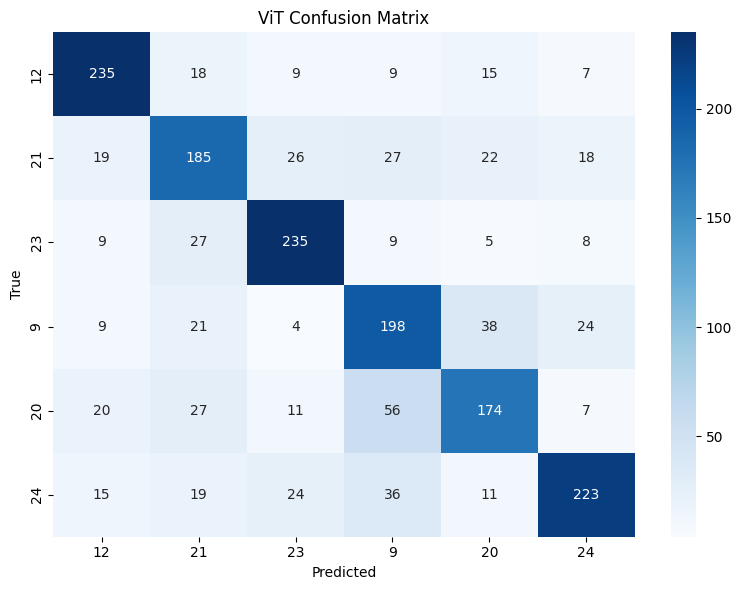

✅ Test results saved to /content/drive/MyDrive/wikiart_project/results/vit_test_results.csv


In [16]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_, _, test_loader = get_dataloaders()


models_info = {
    "SimpleCNN": {
        "class": SimpleCNN(num_classes),
        "ckpt": f"{MODEL_DIR}/simplecnn.pth"
    },
    "ResNet-50": {
        "class": models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),
        "ckpt": f"{MODEL_DIR}/resnet50.pth"
    },
    "ViT": {
        "class": timm.create_model('vit_base_patch16_224', pretrained=True),
        "ckpt": f"{MODEL_DIR}/vit_base.pth"
    }
}


models_info["ResNet-50"]["class"].fc = nn.Linear(
    models_info["ResNet-50"]["class"].fc.in_features, num_classes
)

models_info["ViT"]["class"].head = nn.Linear(
    models_info["ViT"]["class"].head.in_features, num_classes
)

#evaluate all models
results = []
for name, info in models_info.items():
    print(f"\n=== Evaluating {name} ===")
    model = info["class"].to(device)
    model.load_state_dict(torch.load(info["ckpt"], map_location=device))
    model.to(device)

    total_params, trainable_params = count_params(model)

    for param in model.parameters():
        param.requires_grad = False

    # Evaluate
    test_acc, test_f1,test_prec, test_rec, y_true, y_pred = evaluate_metrics(model, test_loader, device)
    print(f"{name} Test Accuracy: {test_acc:.4f}")
    print(f"{name} Test F1 Score: {test_f1:.4f}")
    print(f"{name} Total Parameters: {total_params}")
    print(f"{name} Trainable Parameters: {trainable_params}")

    # Confusion matrix
    plot_confusion_matrix(
        y_true,
        y_pred,
        class_labels=[str(s) for s in selected_styles],
        title=f"{name} Confusion Matrix"
    )

    save_test_results(y_true, y_pred, f"{name.lower().replace(' ', '_')}_test_results.csv")

    results.append({
        "model": name,
        "total_params": total_params,
        "trainable_params": trainable_params,
        "test_acc": test_acc,
        "test_f1": test_f1
    })

    rq_path = f"{RESULTS_DIR}/rq_model_summary.csv"
    df = pd.DataFrame(results)
    df.to_csv(rq_path, index=False)


In [29]:
def prepare_image_for_gradcam(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert("RGB")

    # Keep original size for optional display
    img_for_display = np.array(img).astype(np.float32)/255.0

    # Resize for Grad-CAM visualization
    img_resized = img.resize(target_size)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    tensor = transform(img_resized).unsqueeze(0)
    return tensor, np.array(img_resized).astype(np.float32)/255.0


In [26]:
def gradcam_cnn(model, image_path, device, target_class=None):
    model.eval()
    model.to(device)

    input_tensor, img_for_display = prepare_image_for_gradcam(image_path)
    input_tensor = input_tensor.to(device)

    target_layers = [model.conv3]

    if target_class is None:
        with torch.no_grad():
            output = model(input_tensor)
            target_class = output.argmax(dim=1).item()

    # ✅ no use_cuda here
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(target_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    visualization = show_cam_on_image(img_for_display, grayscale_cam, use_rgb=True)
    return visualization


In [32]:
def gradcam_resnet(model, img_path, device='cpu'):

    # Target the last residual block
    target_layers = [model.layer4[-1]]

    # Initialize Grad-CAM
    cam = GradCAM(model=model, target_layers=target_layers)

    # Prepare input
    input_tensor, rgb_img = prepare_image_for_gradcam(img_path)
    input_tensor = input_tensor.to(device)

    # Generate CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :]

    # Overlay on original image
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    return visualization


In [27]:
def vit_reshape_transform(tensor, height=14, width=14):
    # (B, num_tokens, C) -> remove CLS, to (B, C, H, W)
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def gradcam_vit(model, image_path, device, target_class=None, layer_name=None):
    model.eval()
    model.to(device)

    input_tensor, img_for_display = prepare_image_for_gradcam(image_path)
    input_tensor = input_tensor.to(device)

    if layer_name is None:
        layer_name = model.blocks[-1].norm1 

    target_layers = [layer_name]

    if target_class is None:
        with torch.no_grad():
            output = model(input_tensor)
            target_class = output.argmax(dim=1).item()
    cam = GradCAM(
        model=model,
        target_layers=target_layers,
        reshape_transform=vit_reshape_transform,
    )
    targets = [ClassifierOutputTarget(target_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    visualization = show_cam_on_image(img_for_display, grayscale_cam, use_rgb=True)
    return visualization


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


cnn = SimpleCNN(num_classes)
cnn.load_state_dict(torch.load(f"{MODEL_DIR}/simplecnn.pth",
                               map_location=device))
cnn.to(device)
cnn.eval()

# ResNet-50
resnet = models.resnet50(weights=None)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet.load_state_dict(torch.load(f"{MODEL_DIR}/resnet50.pth",
                                  map_location=device))
resnet.to(device)
resnet.eval()

# ViT
vit = timm.create_model('vit_base_patch16_224', pretrained=False)
vit.head = nn.Linear(vit.head.in_features, num_classes)
vit.load_state_dict(torch.load(f"{MODEL_DIR}/vit_base.pth",
                               map_location=device))
vit.to(device)
vit.eval()

rq2_cases = []
sample_files_path = f"{RESULTS_DIR}/rq2_sample_files.json"

# Reuse same 10 test images
if not os.path.exists(sample_files_path):
    test_files = load_split("test")
    num_samples = min(10, len(test_files)) 
    sample_files = random.sample(test_files, num_samples)
    with open(sample_files_path, "w") as f:
        json.dump(sample_files, f)
else:
    with open(sample_files_path, "r") as f:
        sample_files = json.load(f)

for i, meta_file in enumerate(sample_files):
    with open(meta_file) as f:
        meta = json.load(f)
    img_path = meta["path"]
    true_style = meta["style"]

    input_tensor, _ = prepare_image_for_gradcam(img_path)
    input_tensor = input_tensor.to(device)

    # CNN prediction
    with torch.no_grad():
        cnn_out = cnn(input_tensor)
        cnn_pred_idx = cnn_out.argmax(dim=1).item()
    cnn_pred_style = idx_to_style[cnn_pred_idx]

    # ResNet-50 prediction 
    with torch.no_grad():
        resnet_out = resnet(input_tensor)
        resnet_pred_idx = resnet_out.argmax(dim=1).item()
    resnet_pred_style = idx_to_style[resnet_pred_idx]

    # ViT prediction
    with torch.no_grad():
        vit_out = vit(input_tensor)
        vit_pred_idx = vit_out.argmax(dim=1).item()
    vit_pred_style = idx_to_style[vit_pred_idx]

    # Grad-CAM visualizations
    # SimpleCNN Grad-CAM
    vis_cnn = gradcam_cnn(cnn, img_path, device=device)
    cnn_save_path = f"{CNN_DIR}/gradcam_{i}.png"
    plt.imsave(cnn_save_path, vis_cnn)

    # ResNet-50 Grad-CAM
    vis_resnet = gradcam_resnet(resnet, img_path, device=device)
    resnet_save_path = f"{RESNET_DIR}/gradcam_{i}.png"
    plt.imsave(resnet_save_path, vis_resnet)

    # ViT Grad-CAM
    vis_vit = gradcam_vit(vit, img_path, device=device)
    vit_save_path = f"{VIT_DIR}/gradcam_{i}.png"
    plt.imsave(vit_save_path, vis_vit)

    rq2_cases.append({
        "case_id": i,
        "img_path": img_path,
        "true_style": true_style,
        "cnn_pred_style": cnn_pred_style,
        "resnet_pred_style": resnet_pred_style,
        "vit_pred_style": vit_pred_style,
        "cnn_gradcam_path": cnn_save_path,
        "resnet_gradcam_path": resnet_save_path,
        "vit_gradcam_path": vit_save_path
    })

rq2_cases_path = f"{RESULTS_DIR}/rq2_gradcam_cases.csv"
pd.DataFrame(rq2_cases).to_csv(rq2_cases_path, index=False)
print("Grad-CAM visualizations are completed for all 3 models.")
print(f"RQ2 cases are saved to {rq2_cases_path}")


Grad-CAM visualizations are completed for all 3 models.
RQ2 cases are saved to /content/drive/MyDrive/wikiart_project/results/rq2_gradcam_cases.csv
